# Point 2

## ***Installing libraries***

In [2]:
pip install scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy==2.0.0


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install sounddevice 


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install librosa


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sounddevice as sd


## Recording of 2 audio signals with a background sound and graphing their waveform.

**Functions**

In [27]:
import time
def record_audio(duration = 10, sample_rate = 44100):
    """
    Records an audio signal from the microphone.

    Parameters:
    - duration: Recording duration in seconds.
    - sample_rate: Sampling rate.

    Returns:
    - Recorded audio signal.
    """
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype="float64")
    sd.wait()
    print("Recording finished.")    
    return audio

def obtain_N_audios(n_sounds = 2, sound_duration = 10, sample_rate = 44100):
    """
    Records two audio signals from the microphone.

    Returns:
    - Two audio signals.
    """ 
    sounds = []
    for i in range(n_sounds):
        print(f"Recording audio {i + 1}/{n_sounds}...")
        sounds.append(record_audio(sound_duration, sample_rate))
        sd.wait()

        if i != n_sounds - 1:
            print(f"Audio {i + 1}/{n_sounds} recorded. Wait a moment to record the next audio.")
        else:
            print("Audios recorded.")
        time.sleep(3)

    return np.array(sounds)


def show_sounds(all_sounds, sound_duration = 10, sample_rate = 44100):
    """
    Shows the waveforms of the recorded audio signals
    """
    time = np.linspace(0, sound_duration, int(sound_duration * sample_rate))
    for i in range(all_sounds.shape[0]):
        plt.figure(figsize=(10, 4))
        plt.plot(time, all_sounds[i])
        plt.title(f"Waveform of the audio {i + 1}")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()

def show_sound(sound, sound_duration = 10, sample_rate = 44100):
    """
    Shows the waveform of a single audio signal.
    """
    time = np.linspace(0, sound_duration, int(sound_duration * sample_rate))
    plt.figure(figsize=(10, 4))
    plt.plot(time, sound)
    plt.title("Waveform of the original background audio")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

**Audio Properties definition**

In [28]:
sound_duration = 2
sample_rate = 8000
n_sounds = 2

**Background Audio Vector**

In [29]:
import librosa as lr

background_file = "background.mp3"
print("Processing audio representing the background")
audio_background, sr = lr.load(background_file, sr=sample_rate, duration=sound_duration, mono=True)
desired_length = sample_rate * sound_duration

Processing audio representing the background


**Record audio and Normalize**

In [30]:
all_sounds = obtain_N_audios(n_sounds, sound_duration, sample_rate) 

Recording audio 1/2...
Recording...
Recording finished.
Audio 1/2 recorded. Wait a moment to record the next audio.
Recording audio 2/2...
Recording...
Recording finished.
Audios recorded.


**Normalized Data**

This will be the data for the algorithm (Normalized) - Audio 1 - Audio 2 - Background


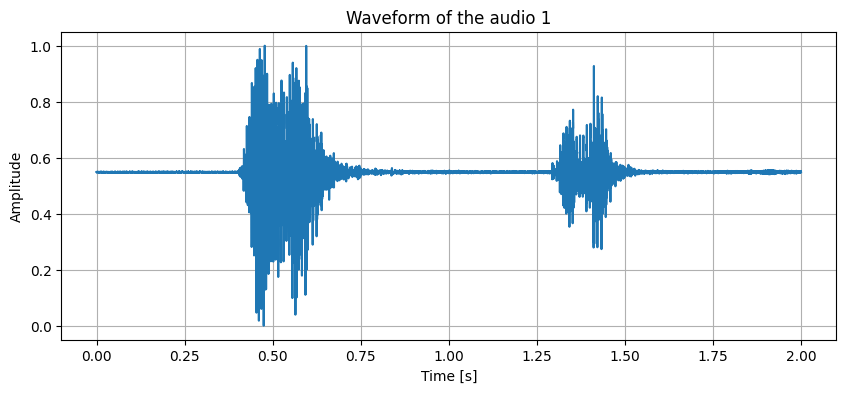

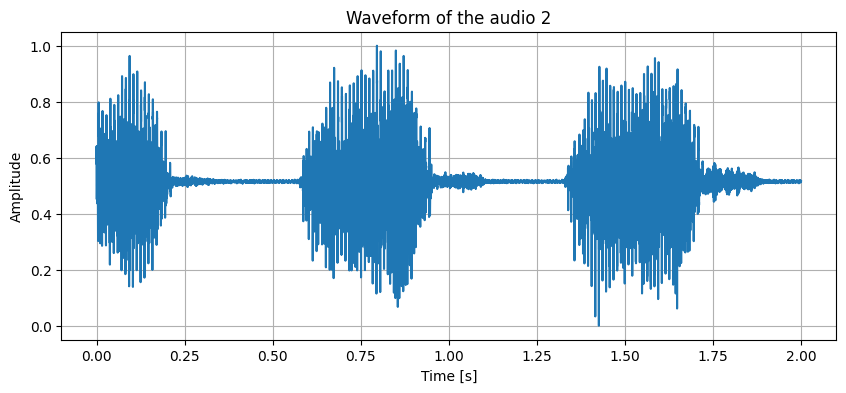

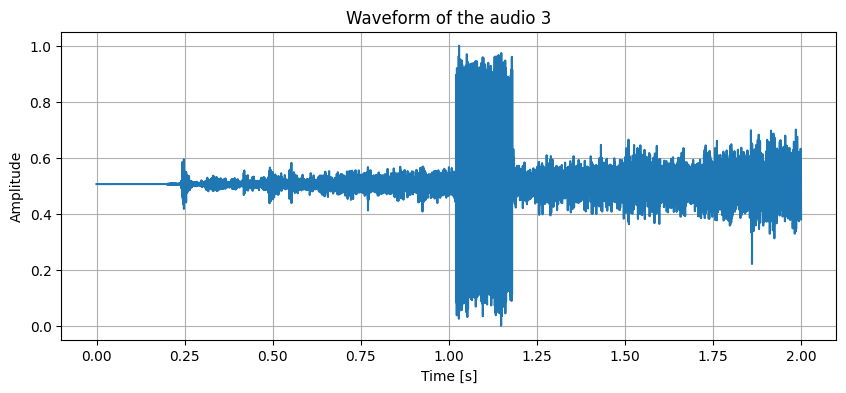

In [31]:
bad_sound_one = np.array([item for sublist in all_sounds[0] for item in sublist])
bad_sound_two = np.array([item for sublist in all_sounds[1] for item in sublist])
bad_sound_bg = audio_background

scaler = skp.MinMaxScaler(feature_range=(0, 1))

nor_sound_one = scaler.fit_transform(bad_sound_one.reshape(-1, 1)).flatten()
nor_sound_two = scaler.fit_transform(bad_sound_two.reshape(-1, 1)).flatten()
nor_sound_bg = scaler.fit_transform(bad_sound_bg.reshape(-1, 1)).flatten()

all_sounds_normalized = np.array([nor_sound_one, nor_sound_two, nor_sound_bg])

print("This will be the data for the algorithm (Normalized) - Audio 1 - Audio 2 - Background")
show_sounds(all_sounds_normalized, sound_duration, sample_rate)

# Adaline Definition

In [32]:
class AdalineMultiOutput:
    def __init__(self, input_size, output_size=3, learning_rate=0.001, epochs=100):
        """
        Initializes the ADALINE network with multiple outputs.

        Parameters:
        - input_size: Number of input features (excluding the bias).
        - output_size: Number of outputs (signals to recover).
        - learning_rate: Learning rate for weight updates.
        - epochs: Number of iterations over the training set.
        """
        self.weights = np.zeros((output_size, input_size + 1))
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.errors = []

    def predict(self, x):
        """
        Makes a prediction for a single input sample.

        Parameters:
        - x: Input vector.

        Returns:
        - Predicted output vector.
        """
        x = np.insert(x, 0, 1)  # Insert bias term

        return np.dot(self.weights, x)

    def train(self, X, D):
        """
        Trains the ADALINE network using the provided dataset.

        Parameters:
        - X: Input matrix (n_samples, input_size).
        - D: Desired output matrix (n_samples, output_size).
        """
        for epoch in range(self.epochs):
            mse_ = 0

            for i in range(len(X)):
                x_i = np.insert(X[i], 0, 1) 
                y = np.dot(self.weights, x_i)  
                error = D[i] - y  
                mse_ += np.sum(error ** 2)
                self.weights += 2 * self.learning_rate * np.outer(error, x_i)
            self.errors.append(np.mean(mse_))

            if (epoch + 1) % 20 == 0:
                y_pred = self.predict_batch(X)
                mse = np.mean((D - y_pred) ** 2)
                self.errors.append(mse)
                print(f"Epoch {epoch + 1}/{self.epochs} - MSE: {mse:.5f}")

    def predict_batch(self, X):
        """
        Makes predictions for a batch of input samples.

        Parameters:
        - X: Input matrix (n_samples, input_size).

        Returns:
        - Predicted output matrix (n_samples, output_size).
        """
        X_bias = np.insert(X, 0, 1, axis=1)  # Insert bias term into all samples
        return np.dot(X_bias, self.weights.T)  # Dot product for all outputs

# ***Training data***

In [33]:
delay = 20
len_of_sounds = (sound_duration * sample_rate)

noisy_audios = nor_sound_bg + nor_sound_one + nor_sound_two
X = np.array([noisy_audios[i : i + delay] for i in range( len_of_sounds - delay )])

delay_audio_one = nor_sound_one[delay:]
delay_audio_two = nor_sound_two[delay:]
delay_audio_bg  = nor_sound_bg[delay:]

# Desired output matrix to train the ADALINE with correct position to adjust the weights
D = np.stack((delay_audio_one, delay_audio_two, delay_audio_bg), axis=1)

## Training the network

In [34]:
output_size=3
learning_rate=0.0001
epochs= 80
adaline = AdalineMultiOutput(delay, output_size, learning_rate, epochs)
adaline.train(X, D)

Epoch 20/80 - MSE: 0.00267
Epoch 40/80 - MSE: 0.00253
Epoch 60/80 - MSE: 0.00247
Epoch 80/80 - MSE: 0.00243


## Signal Recovery

In [36]:
recovered_signals = adaline.predict_batch(X)
recovered_signal_audio_one = recovered_signals[:, 0]
recovered_signal_audio_two = recovered_signals[:, 1]
recovered_signal_audio_bg  = recovered_signals[:, 2]

## Error visualization

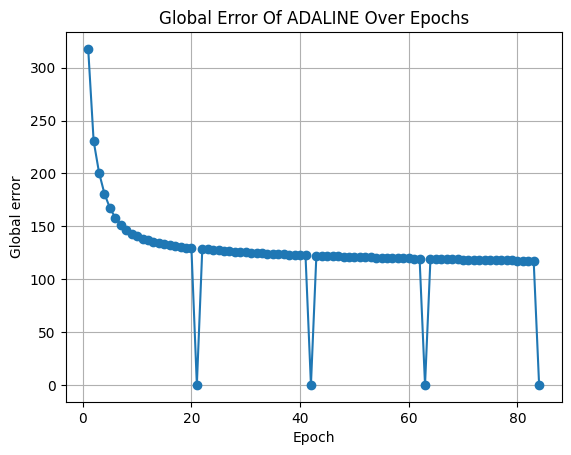

In [37]:
# Plot the MSE over epochs
plt.figure()
plt.plot(range(1, len(adaline.errors) + 1), adaline.errors, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global error')
plt.title('Global Error Of ADALINE Over Epochs')
plt.grid(True)

## Signal Comparision

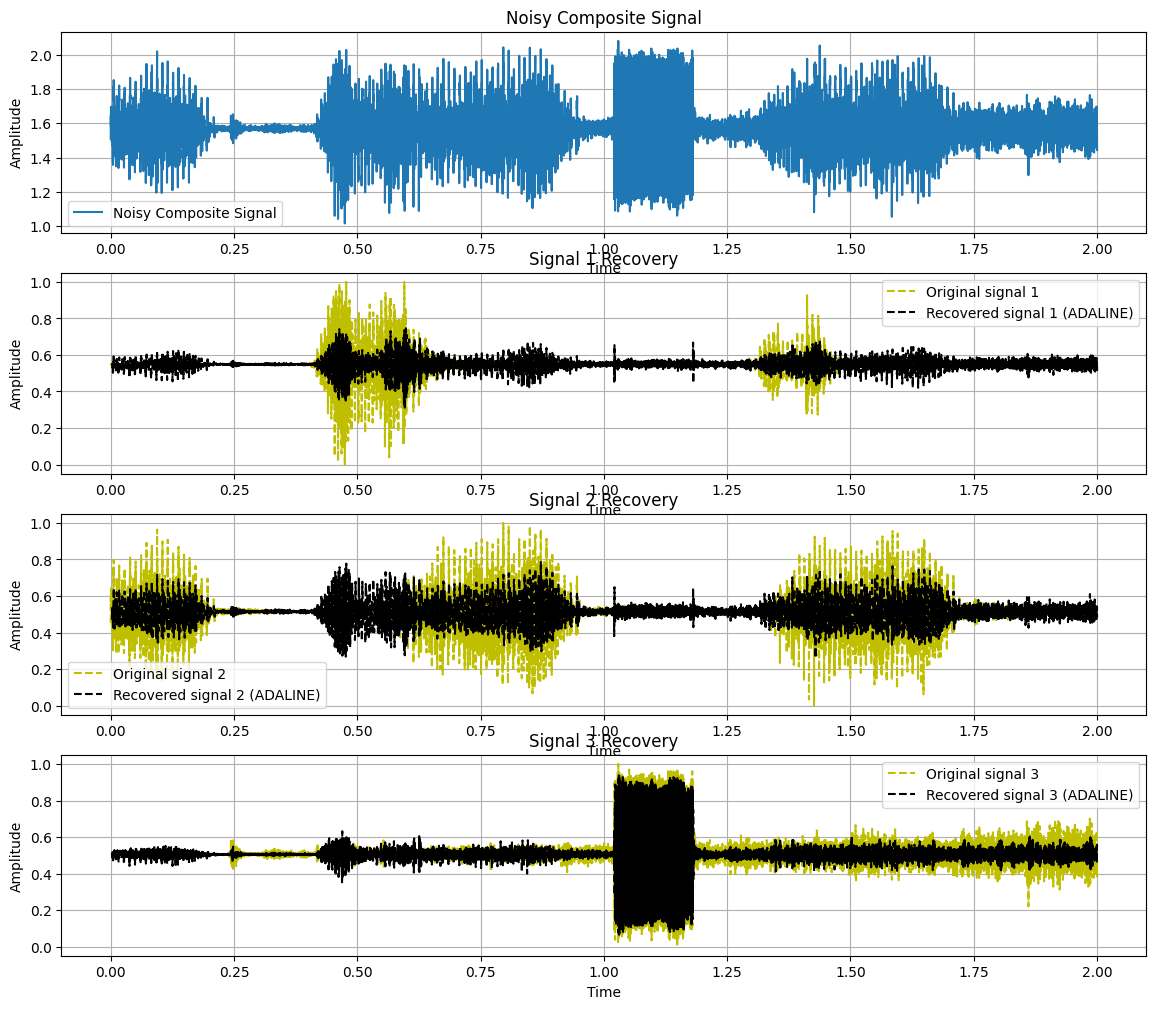

In [38]:
# Plot the original signals, noisy composite signal, and recovered signals
plt.figure(figsize=(14, 12))
time = np.linspace(0, sound_duration, int(sound_duration * sample_rate))

# Noisy composite signal
plt.subplot(4, 1, 1)
plt.plot(time, noisy_audios, label="Noisy Composite Signal")
plt.title("Noisy Composite Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signal 1: Original vs Recovered
plt.subplot(4, 1, 2)
plt.plot(time, nor_sound_one, '--', label="Original signal 1", color="y")
plt.plot(time[delay:], recovered_signal_audio_one, '--', label="Recovered signal 1 (ADALINE)", color="k")
plt.title("Signal 1 Recovery")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signal 2: Original vs Recovered
plt.subplot(4, 1, 3)
plt.plot(time, nor_sound_two, '--', label="Original signal 2", color="y")
plt.plot(time[delay:], recovered_signal_audio_two, '--', label="Recovered signal 2 (ADALINE)", color="k")
plt.title("Signal 2 Recovery")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signal 3: Original vs Recovered
plt.subplot(4, 1, 4)
plt.plot(time, nor_sound_bg, '--', label="Original signal 3", color="y")
plt.plot(time[delay:], recovered_signal_audio_bg, '--', label="Recovered signal 3 (ADALINE)", color="k")
plt.title("Signal 3 Recovery")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# **Sound reproduction**

In [49]:
#Normalize predictions range [0,1] to [-1,1]
#audio_normalized = np.array(noisy_audios) * 2 - 1

prediction_to_show_one      = np.array(recovered_signal_audio_one) * 2 - 1
prediction_to_show_two      = np.array(recovered_signal_audio_two) * 2 - 1
prediction_to_show_three    = np.array(recovered_signal_audio_bg) *  2 - 1
noisy_audios_to_show        = np.array(noisy_audios) * 2 - 1

playing the original audios together


**Sound 1**

In [52]:
print("Playing back original audio one")
sd.play(bad_sound_one, sample_rate)
sd.wait()

print("Playing prediction audio one")
sd.play(prediction_to_show_one, sample_rate)
sd.wait()

Playing back original audio one
Playing prediction audio one


**Sound 2**

In [ ]:
print("Playing back original audio two")
sd.play(bad_sound_two, sample_rate)
sd.wait()
print("Playing prediction audio two")
sd.play(prediction_to_show_two, sample_rate)
sd.wait()

**Sound 3 - Background**

In [53]:
print("Playing back original audio three")
sd.play(bad_sound_bg, sample_rate)
sd.wait()
print("Playing back prediction audio three")
sd.play(prediction_to_show_three, sample_rate)
sd.wait()

Playing back original audio three
Playing back prediction audio three


## **Correlation of expected and achieved outputs**

In [57]:
correlation_audios_one = np.corrcoef(delay_audio_one, recovered_signal_audio_one)[0, 1]
print("Correlation audio 1: ", correlation_audios_one)

correlation_audios_two = np.corrcoef(delay_audio_two, recovered_signal_audio_two)[0, 1]
print("Correlation audio 2: ",correlation_audios_two)

correlation_audios_bg = np.corrcoef(delay_audio_bg, recovered_signal_audio_bg)[0, 1]
print("Correlation audio background: ",correlation_audios_bg)

Correlation audio 1:  0.5737271970777383
Correlation audio 2:  0.684904750535779
Correlation audio background:  0.9108198946356098
